<a href="https://colab.research.google.com/github/IagoMagalhaes23/Detectron2/blob/main/Detectron2_Segmenta%C3%A7%C3%A3o_detec%C3%A7%C3%A3o_e_reconhecimento_de_pontos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalações

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=4e573ce389f87f259e127a475c3e42b9b0e9d20b37c7b69c58793d69c086ac27
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

##Importações

In [2]:
import detectron2

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torch

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


##Lendo uma imagem

In [3]:
!wget https://cdn.cliqueinc.com/posts/241750/how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true&quality=70

--2023-05-21 23:22:29--  https://cdn.cliqueinc.com/posts/241750/how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true
Resolving cdn.cliqueinc.com (cdn.cliqueinc.com)... 13.226.52.77, 13.226.52.49, 13.226.52.116, ...
Connecting to cdn.cliqueinc.com (cdn.cliqueinc.com)|13.226.52.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99265 (97K) [image/jpeg]
Saving to: ‘how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true’

how-to-wear-wide-je 100%[===================>]  96.94K  --.-KB/s    in 0.03s   

2023-05-21 23:22:29 (3.27 MB/s) - ‘how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true’ saved [99265/99265]



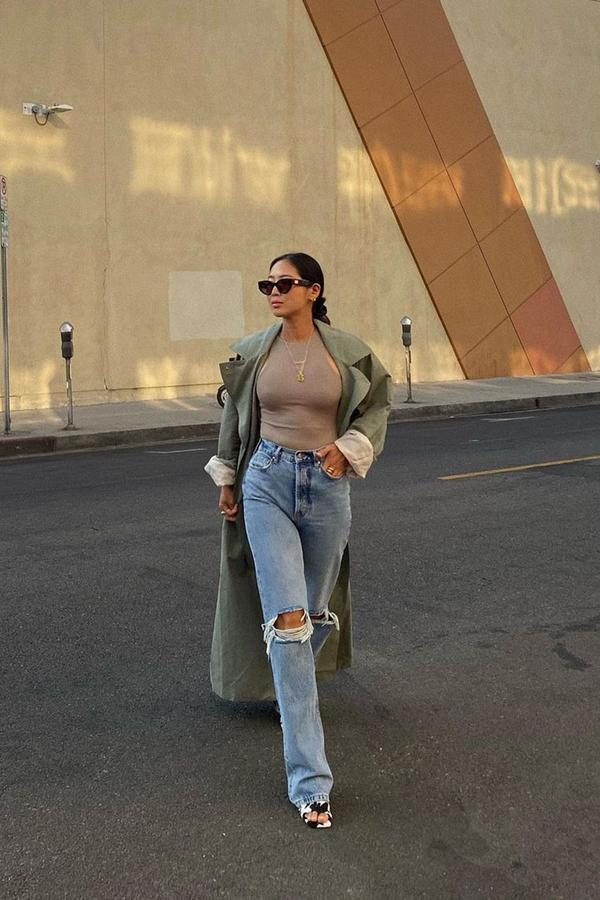

In [4]:
image = cv2.imread('/content/how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true')
cv2_imshow(image)

##Reconhecimento de objetos

[05/21 23:23:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


model_final_f6e8b1.pkl: 243MB [00:02, 117MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([ 0, 12, 12])
Boxes(tensor([[206.7051, 246.6315, 394.8086, 829.4521],
        [399.9874, 315.5877, 412.4106, 347.6339],
        [ 58.9671, 320.3798,  74.1562, 359.6531]]))


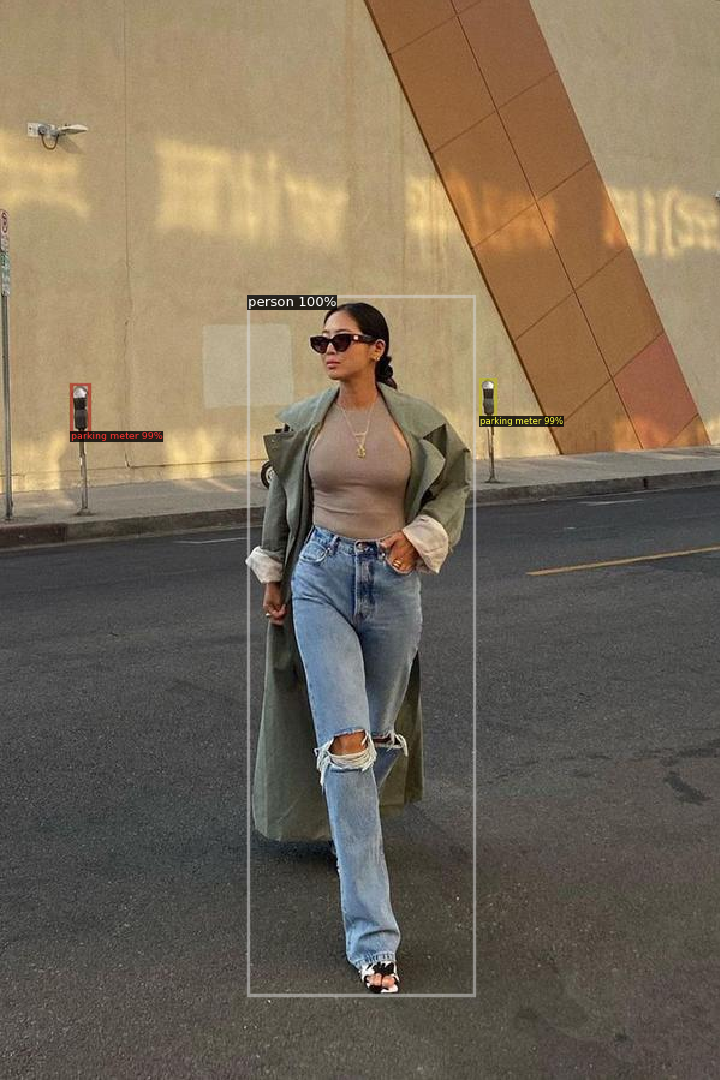

In [5]:
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"

cfg.MODEL.DEVICE = "cpu"

predictor = DefaultPredictor(cfg)

img = cv2.imread('/content/how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true')
outputs = predictor(img)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

##Detecção de pontos

[05/21 23:24:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


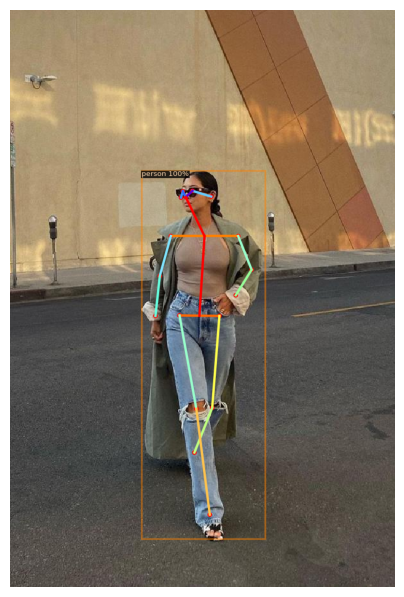

In [8]:
from detectron2 import model_zoo

cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

im = cv2.imread("/content/how-to-wear-wide-jeans-241750-1605148677967-image.600x0c.jpg?interlace=true")

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

##Segmentação Panoptic

[05/21 23:25:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:05, 46.6MB/s]                           


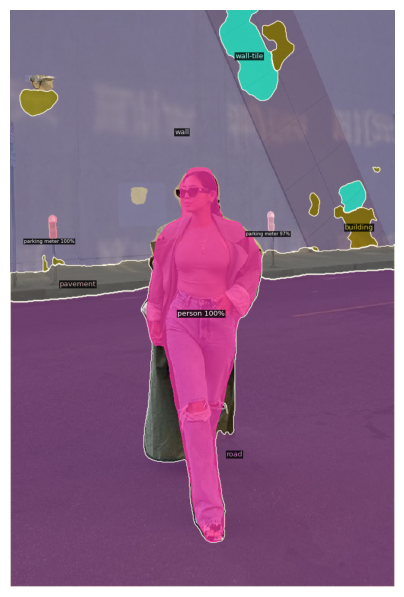

In [9]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

##Segmentação semântica

[05/21 23:25:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:02, 88.4MB/s]                          


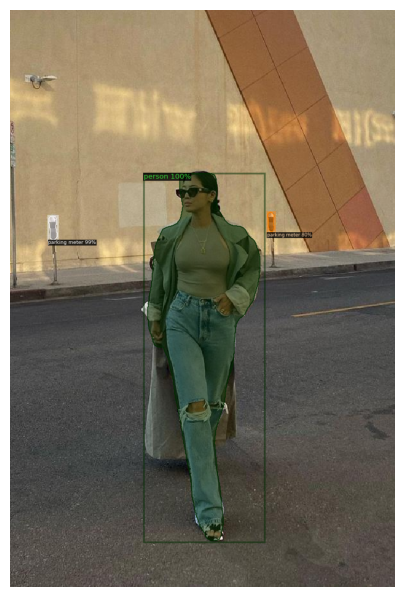

In [10]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])